# Recommender Systems 2024/25

### Practice 7 – Graph-based Models

## Graph-based Recommenders

### What is a Graph?

In layman terms, a graph is a set of **interconnected entities**. Each entity is represented by a *node*, while the connections are called *edges*. Thus, mathematically speaking, a graph $G \in \mathbb{R}^{n\times n}$ can be represented as two sets, $N$ (nodes) and $E$ (edges).$$G = (N,E) \\ N = \{x_i | i \in [1, |N|]_{\mathbb{N}}\} \\ E = \{\{x_i, x_j\} | x_i,x_j \in N\}$$

### Graph Notation

#### Graph Chart

Nodes are usually represented graphically as circles, with lines (=edges) connecting one another

In [1]:
!pip install plotly

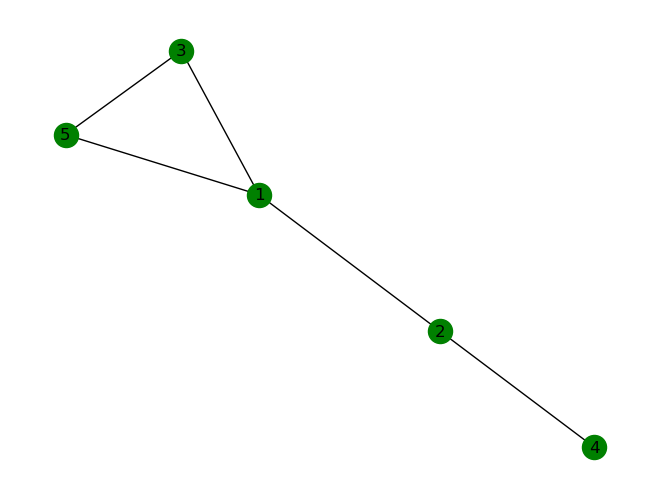

In [2]:
import networkx as nx
import plotly.graph_objects as go

G = nx.Graph()
G.add_nodes_from([1,2,3,4,5])
G.add_edges_from([(1,2),(1,3),(1,5),(2,4),(3,5)])

nx.draw(G, with_labels=True, node_color="green")

In [3]:
# Draw a more beautiful, interactive graph

def setup_plotly_graph(G : nx.Graph):
    pos = nx.spring_layout(G)
    edge_x, edge_y = [], []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]

    node_x, node_y = zip(*pos.values())

    return edge_x, edge_y, node_x, node_y

def draw_plotly(G : nx.Graph):
    edge_x, edge_y, node_x, node_y = setup_plotly_graph(G)

    edge_trace = go.Scatter(x=edge_x, y=edge_y,
                            line=dict(width=1, color='gray'),
                            hoverinfo='none',
                            mode='lines')
    node_trace = go.Scatter(x=node_x, y=node_y,
                            mode='markers+text',
                            marker=dict(size=25, color='blue'),
                            text=list(G.nodes),
                            textposition="top center")

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(title="Example Graph",
                                    showlegend=False,
                                    hovermode='closest'))
    
    return fig

fig = draw_plotly(G)
fig.show()


#### Adjacency Lists

For each node in the graph, its adjacency list contains all nodes it is connected to. Pros: easily readable, cons: redundant

In [4]:
for k,v in G.adj.items():
    print("{}: {}".format(k, list(v.keys())))

1: [2, 3, 5]
2: [1, 4]
3: [1, 5]
4: [2]
5: [1, 3]


#### Adjacency Matrices

##### Node-2-Edge

In [5]:
import numpy as np

def node_to_edge_adjacency_matrix(G : nx.Graph):
    # Get the list of nodes and edges
    nodes = list(G.nodes)
    edges = [(x[0] - 1,x[1] - 1) for x in list(G.edges)]

    # Initialize the node-to-edge adjacency matrix
    n = len(nodes)
    m = len(edges)
    matrix = np.zeros((n, m), dtype=np.int32)

    # Populate the matrix
    for edge_index, (u, v) in enumerate(edges):
        matrix[u, edge_index] = 1
        matrix[v, edge_index] = 1

    return matrix

node_to_edge_adjacency_matrix(G)

array([[1, 1, 1, 0, 0],
       [1, 0, 0, 1, 0],
       [0, 1, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 1]], dtype=int32)

##### Node-2-Node

In [6]:
a = nx.to_numpy_array(G, dtype=np.int32)
a

array([[0, 1, 1, 0, 1],
       [1, 0, 0, 1, 0],
       [1, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [1, 0, 1, 0, 0]], dtype=int32)

### For our purposes, the most convenient form of graph representation are n2n adjacency matrices.

### Graphs in Recommendation
- Nodes: users, items
- Edges: interactions

The graph representation of a recommendation scenario is inherently *bipartite*.

> **Bipartite Graph**: a graph $G$ is bipartite if its set of nodes $N$ can be divided into two **disjoint** sets of nodes, $N_1$ and $N_2$, such that for every edge $e$ in $G$, $e$ connects a node belonging to $N_1$ to a node in $N_2$ or vice versa, thus there is no inter-set connections among nodes within $N_1$ nor $N_2$.

In our case, class $N_1$ is defined by the *user nodes*, and class $N_2$ by *item nodes*, since the edges define user-item interactions.

Consequently, the graph's adjacency matrix will **contain the URM**.

[image]

> **Path**: a sequence of $m + 1$ nodes $n_0 \rightarrow n_1 \rightarrow n_2 \rightarrow ... \rightarrow n_m$ such that $\forall i = 1, ..., m, (n_{i-1}, n_{i}) \in E$.

I.e., a *path* is a sequence of connected nodes within a graph. A path will have a starting node $A$ and a destination node $B$. In the context of recommendation, we can think of paths as **collaborative signals**!

### Random Walks

In [7]:
import time
import numpy as np
import scipy.sparse as sps
from sklearn.preprocessing import normalize

#### Illustrative Example
Let's create a graph $G$ with 2 users, 3 items and the following adjacency matrix: $$\begin{bmatrix}0 & 0 & 1 & 0 & 1 \\ 0 & 0 & 1 & 1 & 0 \\ 1 & 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0 \\ 1 & 0 & 0 & 0 & 0\end{bmatrix}.$$

It corresponds to the following schema:

In [8]:
G = nx.from_dict_of_dicts({
    0 : {2 : {}, 4 : {}},
    1 : {2 : {}, 3 : {}},
    2 : {0 : {}, 1 : {}},
    3 : {1 : {}},
    4 : {0 : {}}
})

draw_plotly(G)

In [9]:
a = nx.to_numpy_array(G, dtype=np.int32)
a

array([[0, 0, 1, 0, 1],
       [0, 0, 1, 1, 0],
       [1, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0]], dtype=int32)

In [10]:
# Transition probability function
def transition(g : np.ndarray, n0 : int, hops : int):
    # initial state
    state = np.zeros(g.shape[1], dtype=np.float32)
    state[n0] = 1

    # compute transition probability matrix (can be done once)
    transition_probability_matrix = np.array([x / x.sum().astype(np.float32) for x in g], dtype=np.float32)
    # print(transition_probability_matrix)

    j = 0
    print("Hop: 0, state: {}".format(state))
    while j != hops:
        state = state.dot(transition_probability_matrix)
        print("Hop: {}, state: {}".format(j+1, state))
        j += 1
    return state

In [11]:
transition(g=a, n0=0, hops=3)

Hop: 0, state: [1. 0. 0. 0. 0.]
Hop: 1, state: [0.  0.  0.5 0.  0.5]
Hop: 2, state: [0.75 0.25 0.   0.   0.  ]
Hop: 3, state: [0.    0.    0.5   0.125 0.375]


array([0.   , 0.   , 0.5  , 0.125, 0.375], dtype=float32)

#### Steady State

In [12]:
transition(g=a, n0=0, hops=50)

Hop: 0, state: [1. 0. 0. 0. 0.]
Hop: 1, state: [0.  0.  0.5 0.  0.5]
Hop: 2, state: [0.75 0.25 0.   0.   0.  ]
Hop: 3, state: [0.    0.    0.5   0.125 0.375]
Hop: 4, state: [0.625 0.375 0.    0.    0.   ]
Hop: 5, state: [0.     0.     0.5    0.1875 0.3125]
Hop: 6, state: [0.5625 0.4375 0.     0.     0.    ]
Hop: 7, state: [0.      0.      0.5     0.21875 0.28125]
Hop: 8, state: [0.53125 0.46875 0.      0.      0.     ]
Hop: 9, state: [0.       0.       0.5      0.234375 0.265625]
Hop: 10, state: [0.515625 0.484375 0.       0.       0.      ]
Hop: 11, state: [0.        0.        0.5       0.2421875 0.2578125]
Hop: 12, state: [0.5078125 0.4921875 0.        0.        0.       ]
Hop: 13, state: [0.         0.         0.5        0.24609375 0.25390625]
Hop: 14, state: [0.50390625 0.49609375 0.         0.         0.        ]
Hop: 15, state: [0.         0.         0.5        0.24804688 0.25195312]
Hop: 16, state: [0.5019531  0.49804688 0.         0.         0.        ]
Hop: 17, state: [0.     

array([0.5, 0.5, 0. , 0. , 0. ], dtype=float32)

### $P^3$, $P^3_\alpha$, $RP^3_\beta$

In [13]:
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Data_manager.Movielens.Movielens10MReader import Movielens10MReader

data_reader = Movielens10MReader()
data_loaded = data_reader.load_data()

URM_all = data_loaded.get_URM_all()

URM_train_val, URM_test = split_train_in_two_percentage_global_sample(URM_all, 0.8)
URM_train, URM_val = split_train_in_two_percentage_global_sample(URM_train_val, 0.8)

Movielens10M: Verifying data consistency...
Movielens10M: Verifying data consistency... Passed!
DataReader: current dataset is: Movielens10M
	Number of items: 10681
	Number of users: 69878
	Number of interactions in URM_all: 10000054
	Value range in URM_all: 0.50-5.00
	Interaction density: 1.34E-02
	Interactions per user:
		 Min: 2.00E+01
		 Avg: 1.43E+02
		 Max: 7.36E+03
	Interactions per item:
		 Min: 0.00E+00
		 Avg: 9.36E+02
		 Max: 3.49E+04
	Gini Index: 0.57

	ICM name: ICM_tags, Value range: 1.00 / 69.00, Num features: 10106, feature occurrences: 106820, density 9.90E-04
	ICM name: ICM_genres, Value range: 1.00 / 1.00, Num features: 20, feature occurrences: 21564, density 1.01E-01
	ICM name: ICM_all, Value range: 1.00 / 69.00, Num features: 10126, feature occurrences: 128384, density 1.19E-03
	ICM name: ICM_year, Value range: 1.92E+03 / 2.01E+03, Num features: 1, feature occurrences: 10681, density 1.00E+00




Spiegone di come segmentare la URM in $P_{ui}$ e $P_{iu}$ e di cosa sono a livello pratico questi due segmenti (= URM normalizzata per righe, URM normalizzata per colonne e trasposta)

In [14]:
def transition_matrix(g : np.ndarray, hops : int):
    # initial state
    state = np.diag(np.ones(g.shape))

    # compute transition probability matrix (can be done once)
    transition_probability_matrix = np.array([x / x.sum().astype(np.float32) for x in g], dtype=np.float32) # -> this is equivalent to a column-wise l1 normalization
    # print(transition_probability_matrix)

    j = 0
    print("Hop: 0, state: {}".format(state))
    while j != hops:
        state = state.dot(transition_probability_matrix)
        print("Hop: {}, state: {}".format(j+1, state))
        j += 1
    return state

In [15]:
class Incremental_Similarity_Builder:
    
    def __init__(self, matrix_size_0, matrix_size_1, initial_data_block = 10000000, additional_data_block = 10000000, dtype = np.float32):

        self._matrix_size = [matrix_size_0, matrix_size_1]
        self._initial_data_block = initial_data_block
        self._additional_data_block = additional_data_block
        self._next_cell_pointer = 0

        self._dtype_data = dtype
        self._dtype_coordinates = np.uint32
        self._max_value_of_coordinate_dtype = np.iinfo(self._dtype_coordinates).max

        self._row_array = np.zeros(self._initial_data_block, dtype=self._dtype_coordinates)
        self._col_array = np.zeros(self._initial_data_block, dtype=self._dtype_coordinates)
        self._data_array = np.zeros(self._initial_data_block, dtype=self._dtype_data)


    def add_data_lists(self, row_list_to_add, col_list_to_add, data_list_to_add):

        for data_point_index in range(len(row_list_to_add)):

            if self._next_cell_pointer == len(self._row_array):
                self._row_array = np.concatenate((self._row_array, np.zeros(self._additional_data_block, dtype=self._dtype_coordinates)))
                self._col_array = np.concatenate((self._col_array, np.zeros(self._additional_data_block, dtype=self._dtype_coordinates)))
                self._data_array = np.concatenate((self._data_array, np.zeros(self._additional_data_block, dtype=self._dtype_data)))

            self._row_array[self._next_cell_pointer] = row_list_to_add[data_point_index]
            self._col_array[self._next_cell_pointer] = col_list_to_add[data_point_index]
            self._data_array[self._next_cell_pointer] = data_list_to_add[data_point_index]

            self._next_cell_pointer += 1

    def get_SparseMatrix(self):

        shape = (self._matrix_size[0], self._matrix_size[1])

        sparseMatrix = sps.csr_matrix((self._data_array[:self._next_cell_pointer],
                                       (self._row_array[:self._next_cell_pointer], self._col_array[:self._next_cell_pointer])),
                                      shape=shape,
                                      dtype=self._dtype_data)

        sparseMatrix.eliminate_zeros()

        return sparseMatrix

In [29]:
from Recommenders.Recommender_utils import similarityMatrixTopK

def block_mul(matrix_1, matrix_2, block_dim : int = 200, topK = 100, normalize_sim : bool = False, degree = None):

    similarity_builder = Incremental_Similarity_Builder(matrix_1.shape[0], matrix_2.shape[1], initial_data_block=matrix_2.shape[1]*topK, dtype = np.float32)

    for current_block_start_row in range(0, matrix_1.shape[0], block_dim):

        if current_block_start_row + block_dim > matrix_1.shape[0]:
            block_dim = matrix_1.shape[0] - current_block_start_row

        similarity_block = matrix_1[current_block_start_row:current_block_start_row + block_dim, :] * matrix_2
        similarity_block = similarity_block.toarray()

        for row_in_block in range(block_dim):
            row_data = similarity_block[row_in_block, :]
            if degree is not None : row_data = np.multiply(row_data, degree)
            if current_block_start_row + row_in_block < matrix_2.shape[1]:
                row_data[current_block_start_row + row_in_block] = 0 # <-- elements on diagonal are set to 0, prevent obvious solution

            relevant_items_partition = np.argpartition(-row_data, topK-1, axis=0)[:topK]
            row_data = row_data[relevant_items_partition]

            # Incrementally build sparse matrix, do not add zeros
            if np.any(row_data == 0.0):
                non_zero_mask = row_data != 0.0
                relevant_items_partition = relevant_items_partition[non_zero_mask]
                row_data = row_data[non_zero_mask]

            similarity_builder.add_data_lists(row_list_to_add=np.ones(len(row_data), dtype = np.int32) * (current_block_start_row + row_in_block),
                                            col_list_to_add=relevant_items_partition,
                                            data_list_to_add=row_data)

    W_sparse = similarity_builder.get_SparseMatrix()

    if normalize_sim:
        W_sparse = normalize(W_sparse, norm='l1', axis=1)

    if topK and W_sparse.get_shape()[0] == W_sparse.get_shape()[1]:
        W_sparse = similarityMatrixTopK(W_sparse, k=topK)

    return W_sparse

In [17]:
# We don't need to compute the full matrix, we just need Pui and Piu which we can compute from the URM
def transition_matrix_blocks(URM, hops : int, alpha : float = 1., beta : float = 1., topK : int = 100, extract_similarity : bool = False, normalize_sim : bool = False):

    # compute Pui (column-wise l1 norm)
    P_ui = normalize(URM, norm='l1', axis=1)

    # compute Piu (column-wise l1 norm over TRANSPOSED URM)
    t_URM = URM.transpose(copy=True)
    t_URM.data = np.ones(t_URM.data.size, np.float32) # <- we binarize: weights, if present, are already in P_ui

    if beta != 1. : # RP3beta

        t_URM_sum = np.array(t_URM.sum(axis=1)).ravel()
        degree = np.zeros(URM.shape[1])

        non_zero_mask = (t_URM_sum!=0.0)
        degree[non_zero_mask] = np.power(t_URM_sum[non_zero_mask], -beta)
    else : degree = None

    P_iu = normalize(t_URM, norm='l1', axis=1) # <- axis is still 1, because transposition was performed beforehand
    del(t_URM) # <- save memory

    if alpha != 1. : # P3alpha
        P_ui = P_ui.power(alpha)
        P_iu = P_iu.power(alpha)

    j = 1
    state = P_ui # <- doesn't work for hops < 1, but hops < 1 makes no sense 
    deg = None

    # equivalence to similarity item-based model: extracting sim matrix could be useful for hybrids
    sim_matrix = P_iu if extract_similarity else None
    
    while j < hops:
        if j == hops - 1: deg = degree
        if j % 2 != 0:
            state = block_mul(state, P_iu, topK=topK, normalize_sim=normalize_sim, degree=deg) # state * P_iu
            if extract_similarity and (j > 1 and j < hops - 1) :
                sim_matrix = block_mul(sim_matrix, P_iu, topK=topK, normalize_sim=normalize_sim, degree=deg) # sim_matrix * P_iu
        else:
            state = block_mul(state, P_ui, topK=topK, normalize_sim=normalize_sim, degree=deg) # state * P_ui
            if extract_similarity and (j >= 1 and j < hops - 1) :
                sim_matrix = block_mul(sim_matrix, P_ui, topK=topK, normalize_sim=normalize_sim, degree=deg) # sim_matrix * P_ui
        j += 1

    return state, sim_matrix

In [22]:
from typing import Optional
from Recommenders.BaseRecommender import BaseRecommender

class P3Recommender(BaseRecommender):
    def __init__(self, URM, topK : int = 100, normalize_sim : bool = False):
        super().__init__(URM)
        self.topK = topK
        self.normalize_sim = normalize_sim

    def fit(self):
        self.three_step_walk, _ = transition_matrix_blocks(self.URM_train,
                                                           3,
                                                           topK=self.topK,
                                                           normalize_sim=self.normalize_sim,
                                                           extract_similarity=False)

    def recommend(self, user_id, remove_seen : bool = True, at : Optional[int] = None):
        Pi_0 = np.zeros(self.URM_train.shape[0], dtype=np.int32)
        Pi_0[user_id] = 1
        Pi_0 = sps.csr_matrix(Pi_0)

        ranking = Pi_0.dot(self.three_step_walk).toarray().ravel()

        if remove_seen:
            user_profile_start = self.URM_train.indptr[user_id]
            user_profile_end = self.URM_train.indptr[user_id+1]
            
            seen_items = self.URM_train.indices[user_profile_start:user_profile_end]
            
            ranking[seen_items] = -np.inf
            
        ranking = np.flip(np.argsort(ranking))
        return ranking[:at]

In [19]:
class P3alphaRecommender(BaseRecommender):
    def __init__(self, URM, alpha, topK : int = 100, normalize_sim : bool = False, extract_similarity=False):
        super().__init__(URM)
        self.alpha = alpha
        self.topK = topK
        self.normalize_sim = normalize_sim
        self.extract_similarity = extract_similarity

    def fit(self):
        self.three_step_walk, self.sim_matrix = transition_matrix_blocks(self.URM_train,
                                                                         3,
                                                                         self.alpha,
                                                                         topK=self.topK,
                                                                         extract_similarity=self.extract_similarity,
                                                                         normalize_sim=self.normalize_sim) # <- only change wrt P3 is the alpha exponent

    def recommend(self, user_id, remove_seen : bool = True, at : Optional[int] = None):
        Pi_0 = np.zeros(self.URM_train.shape[0], dtype=np.int32)
        Pi_0[user_id] = 1
        Pi_0 = sps.csr_matrix(Pi_0)

        ranking = Pi_0.dot(self.three_step_walk).toarray().ravel()

        if remove_seen:
            user_profile_start = self.URM_train.indptr[user_id]
            user_profile_end = self.URM_train.indptr[user_id+1]
            
            seen_items = self.URM_train.indices[user_profile_start:user_profile_end]
            
            ranking[seen_items] = -np.inf
            
        ranking = np.flip(np.argsort(ranking))
        return ranking[:at]

In [20]:
class RP3betaRecommender(BaseRecommender):
    def __init__(self, URM, alpha, beta, topK : int = 100, normalize_sim : bool = False):
        super().__init__(URM)
        self.alpha = alpha
        self.beta = beta
        self.topK = topK
        self.normalize_sim = normalize_sim

    def fit(self):
        self.three_step_walk, _ = transition_matrix_blocks(self.URM_train,
                                                           3,
                                                           self.alpha,
                                                           self.beta,
                                                           topK=self.topK,
                                                           normalize_sim=self.normalize_sim,
                                                           extract_similarity=False) # <- only change wrt P3alpha is beta

    def recommend(self, user_id, remove_seen : bool = True, at : Optional[int] = None):
        Pi_0 = np.zeros(self.URM_train.shape[0], dtype=np.int32)
        Pi_0[user_id] = 1
        Pi_0 = sps.csr_matrix(Pi_0)

        ranking = Pi_0.dot(self.three_step_walk).toarray().ravel()

        if remove_seen:
            user_profile_start = self.URM_train.indptr[user_id]
            user_profile_end = self.URM_train.indptr[user_id+1]
            
            seen_items = self.URM_train.indices[user_profile_start:user_profile_end]
            
            ranking[seen_items] = -np.inf
            
        ranking = np.flip(np.argsort(ranking))
        return ranking[:at]

In [21]:
def precision(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    
    return precision_score

def recall(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    
    return recall_score

def AP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    
    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

def evaluate_recommender(URM_test : sps.csr_matrix, recommender : BaseRecommender, cutoff : int = 10):
    
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_AP = 0.0
    
    num_eval = 0

    for user_id in range(URM_test.shape[0]):

        relevant_items = URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]]
        
        if len(relevant_items)>0:
            
            recommended_items = recommender.recommend(user_id, at=cutoff)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)
            
    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    MAP = cumulative_AP / num_eval
    
    print("Recommender results are: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, MAP)) 
    
    return MAP

In [30]:
# PRAXIS WHEN USING THE COURSE'S FRAMEWORK: USE EvaluatorHoldout FOR EVALUATIONS
# from Evaluation.Evaluator import EvaluatorHoldout
# evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])
from Utils.seconds_to_biggest_unit import seconds_to_biggest_unit

models = {
    'P3' : P3Recommender(URM_train_val),
    'P3alpha' : P3alphaRecommender(URM_train_val, alpha=0.5, extract_similarity=True),
    'RP3beta' : RP3betaRecommender(URM_train_val, alpha=0.5, beta=0.3)
}

for model_name, model_obj in models.items():
    time_start = time.time()
    model_obj.fit()
    time_end_value, time_unit = seconds_to_biggest_unit(time.time() - time_start)
    # PRAXIS WHEN USING THE COURSE'S FRAMEWORK: result_df, _ = evaluator_test.evaluateRecommender(model_obj)
    _ = evaluate_recommender(URM_test, model_obj)
    print("{} trained in {:.2f} {}".format(model_name, time_end_value, time_unit))

Recommender_Base_Class: URM Detected 30 ( 0.3%) items with no interactions.
Recommender_Base_Class: URM Detected 30 ( 0.3%) items with no interactions.
Recommender_Base_Class: URM Detected 30 ( 0.3%) items with no interactions.
Recommender results are: Precision = 0.1476, Recall = 0.1232, MAP = 0.0988
P3 trained in 2.76 min
Recommender results are: Precision = 0.1893, Recall = 0.1295, MAP = 0.1283
P3alpha trained in 2.79 min
Recommender results are: Precision = 0.0716, Recall = 0.0655, MAP = 0.0410
RP3beta trained in 2.80 min


In [24]:
# Create and launch optuna study for each recommender. Optimize for MAP@10.
import pandas as pd

import optuna

def objective_function_P3alpha(optuna_trial):
    recommender_instance = P3alphaRecommender(URM_train,
                                              alpha=optuna_trial.suggest_float("alpha", 0.01, 0.99),
                                              topK=optuna_trial.suggest_int("topK", 5, 150),
                                              normalize_sim=optuna_trial.suggest_int("normalize_sim", 0, 1))

    recommender_instance.fit()

    evaluation = evaluate_recommender(URM_val, recommender_instance)
    return evaluation

def objective_function_RP3beta(optuna_trial):
    recommender_instance = RP3betaRecommender(URM_train,
                                              alpha=optuna_trial.suggest_float("alpha", 0.01, 0.99),
                                              beta=optuna_trial.suggest_float("beta", 0.01, 0.99),
                                              topK=optuna_trial.suggest_int("topK", 5, 150),
                                              normalize_sim=optuna_trial.suggest_int("normalize_sim", 0, 1))
    
    recommender_instance.fit()
    
    evaluation = evaluate_recommender(URM_val, recommender_instance)
    return evaluation

class SaveResults(object):
    
    def __init__(self):
        self.results_df = pd.DataFrame(columns = ["result"])
    
    def __call__(self, optuna_study, optuna_trial):
        hyperparam_dict = optuna_trial.params.copy()
        hyperparam_dict["result"] = optuna_trial.values[0]
        
        self.results_df = pd.concat([self.results_df, pd.DataFrame([hyperparam_dict])], ignore_index=True)

optuna_study_P3alpha = optuna.create_study(direction="maximize")
optuna_study_RP3beta = optuna.create_study(direction="maximize")
save_results_P3alpha = SaveResults()
save_results_RP3beta = SaveResults()

[I 2024-12-04 20:35:47,175] A new study created in memory with name: no-name-1c586a1a-a41b-4d0c-bb46-2340bd5420ba
[I 2024-12-04 20:35:47,176] A new study created in memory with name: no-name-f5952fa5-8ce8-414d-9e1d-db677658d0cc


In [ ]:
optuna_study_P3alpha.optimize(objective_function_P3alpha,
                              callbacks=[save_results_P3alpha],
                              n_trials=10)

P3alpha_optimal = P3alphaRecommender(URM_train_val,
                                     alpha=optuna_study_P3alpha.best_trial.params['alpha'],
                                     topK=optuna_study_P3alpha.best_trial.params['topK'],
                                     normalize_sim=optuna_study_P3alpha.best_trial.params['normalize_sim'])
P3alpha_optimal.fit()
_ = evaluate_recommender(URM_test, P3alpha_optimal)

Recommender_Base_Class: URM Detected 72 ( 0.7%) items with no interactions.


[I 2024-12-04 20:38:45,228] Trial 0 finished with value: 0.006694260740213139 and parameters: {'alpha': 0.5899194477180066, 'topK': 37, 'normalize_sim': 0}. Best is trial 0 with value: 0.006694260740213139.


Recommender results are: Precision = 0.0117, Recall = 0.0115, MAP = 0.0067
Recommender_Base_Class: URM Detected 72 ( 0.7%) items with no interactions.


/var/folders/pp/q0kl1bl507q_7gsf1tczbrg80000gn/T/ipykernel_27011/1586423476.py:38: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-12-04 20:41:23,768] Trial 1 finished with value: 0.0008956223793501028 and parameters: {'alpha': 0.7714878927849269, 'topK': 6, 'normalize_sim': 1}. Best is trial 0 with value: 0.006694260740213139.


Recommender results are: Precision = 0.0015, Recall = 0.0013, MAP = 0.0009
Recommender_Base_Class: URM Detected 72 ( 0.7%) items with no interactions.


[I 2024-12-04 20:44:04,028] Trial 2 finished with value: 0.001726481309040288 and parameters: {'alpha': 0.216046814298171, 'topK': 14, 'normalize_sim': 1}. Best is trial 0 with value: 0.006694260740213139.


Recommender results are: Precision = 0.0028, Recall = 0.0034, MAP = 0.0017
Recommender_Base_Class: URM Detected 72 ( 0.7%) items with no interactions.


[I 2024-12-04 20:47:15,512] Trial 3 finished with value: 0.010524751320367044 and parameters: {'alpha': 0.5800063379424116, 'topK': 85, 'normalize_sim': 0}. Best is trial 3 with value: 0.010524751320367044.


Recommender results are: Precision = 0.0182, Recall = 0.0164, MAP = 0.0105
Recommender_Base_Class: URM Detected 72 ( 0.7%) items with no interactions.


[I 2024-12-04 20:50:19,278] Trial 4 finished with value: 0.009202902238789489 and parameters: {'alpha': 0.2549736805878891, 'topK': 69, 'normalize_sim': 0}. Best is trial 3 with value: 0.010524751320367044.


Recommender results are: Precision = 0.0161, Recall = 0.0143, MAP = 0.0092
Recommender_Base_Class: URM Detected 31 ( 0.3%) items with no interactions.
Recommender results are: Precision = 0.0267, Recall = 0.0186, MAP = 0.0174


In [ ]:
optuna_study_RP3beta.optimize(objective_function_RP3beta,
                              callbacks=[save_results_RP3beta],
                              n_trials=10)

RP3beta_optimal = RP3betaRecommender(URM_train_val,
                                     alpha=optuna_study_RP3beta.best_trial.params['alpha'],
                                     beta=optuna_study_RP3beta.best_trial.params['beta'],
                                     topK=optuna_study_RP3beta.best_trial.params['topK'],
                                     normalize_sim=optuna_study_RP3beta.best_trial.params['normalize_sim'])

RP3beta_optimal.fit()
_ = evaluate_recommender(URM_test, RP3beta_optimal)

Recommender_Base_Class: URM Detected 72 ( 0.7%) items with no interactions.


[I 2024-12-04 20:57:02,678] Trial 0 finished with value: 0.0002730776178356295 and parameters: {'alpha': 0.2544338328123648, 'beta': 0.8904674609231894, 'topK': 123, 'normalize_sim': 0}. Best is trial 0 with value: 0.0002730776178356295.


Recommender results are: Precision = 0.0010, Recall = 0.0005, MAP = 0.0003
Recommender_Base_Class: URM Detected 72 ( 0.7%) items with no interactions.


/var/folders/pp/q0kl1bl507q_7gsf1tczbrg80000gn/T/ipykernel_27011/1586423476.py:38: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-12-04 20:59:41,792] Trial 1 finished with value: 0.00061846358461049 and parameters: {'alpha': 0.7084689139911232, 'beta': 0.35012782035220247, 'topK': 13, 'normalize_sim': 1}. Best is trial 1 with value: 0.00061846358461049.


Recommender results are: Precision = 0.0014, Recall = 0.0011, MAP = 0.0006
Recommender_Base_Class: URM Detected 72 ( 0.7%) items with no interactions.


[I 2024-12-04 21:02:34,918] Trial 2 finished with value: 0.005149190403053552 and parameters: {'alpha': 0.9860659413133749, 'beta': 0.2737152607122167, 'topK': 112, 'normalize_sim': 1}. Best is trial 2 with value: 0.005149190403053552.


Recommender results are: Precision = 0.0092, Recall = 0.0114, MAP = 0.0051
Recommender_Base_Class: URM Detected 72 ( 0.7%) items with no interactions.


[I 2024-12-04 21:05:31,073] Trial 3 finished with value: 0.002486947250127668 and parameters: {'alpha': 0.12408556401058285, 'beta': 0.3856286009246712, 'topK': 138, 'normalize_sim': 1}. Best is trial 2 with value: 0.005149190403053552.


Recommender results are: Precision = 0.0044, Recall = 0.0061, MAP = 0.0025
Recommender_Base_Class: URM Detected 72 ( 0.7%) items with no interactions.


[I 2024-12-04 21:08:13,595] Trial 4 finished with value: 0.0003894052203038603 and parameters: {'alpha': 0.9134182890657323, 'beta': 0.6364300585634282, 'topK': 10, 'normalize_sim': 0}. Best is trial 2 with value: 0.005149190403053552.


Recommender results are: Precision = 0.0012, Recall = 0.0007, MAP = 0.0004
Recommender_Base_Class: URM Detected 72 ( 0.7%) items with no interactions.


[I 2024-12-04 21:10:59,057] Trial 5 finished with value: 0.0021019845929534315 and parameters: {'alpha': 0.5182343422760697, 'beta': 0.20326885748738052, 'topK': 25, 'normalize_sim': 0}. Best is trial 2 with value: 0.005149190403053552.


Recommender results are: Precision = 0.0041, Recall = 0.0048, MAP = 0.0021
Recommender_Base_Class: URM Detected 72 ( 0.7%) items with no interactions.


[W 2024-12-04 21:12:07,894] Trial 6 failed with parameters: {'alpha': 0.976956400954016, 'beta': 0.02293845882419864, 'topK': 138, 'normalize_sim': 1} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/envs/RSFramework/lib/python3.9/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/pp/q0kl1bl507q_7gsf1tczbrg80000gn/T/ipykernel_27011/1586423476.py", line 24, in objective_function_RP3beta
    recommender_instance.fit()
  File "/var/folders/pp/q0kl1bl507q_7gsf1tczbrg80000gn/T/ipykernel_27011/3151860532.py", line 10, in fit
    self.three_step_walk, _ = transition_matrix_blocks(self.URM_train,
  File "/var/folders/pp/q0kl1bl507q_7gsf1tczbrg80000gn/T/ipykernel_27011/1979058723.py", line 37, in transition_matrix_blocks
    state = block_mul(state, P_iu, topK=topK, normalize_sim=normalize_sim, degree=deg) # state * P_iu
  File "/var/folders/

KeyboardInterrupt: 

In [ ]:
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Evaluation.Evaluator import EvaluatorHoldout

recommender_fw = RP3betaRecommender(URM_train_val)
recommender_fw.fit(alpha=RP3beta_optimal.alpha, beta=RP3beta_optimal.beta, topK=RP3beta_optimal.topK, normalize_similarity=RP3beta_optimal.normalize_sim)

evaluator_test = EvaluatorHoldout(URM_test, [10])

# evaluate_recommender(URM_test, recommender_try)
result_fw_df, _ = evaluator_test.evaluateRecommender(recommender_fw)
result_fw_df

RP3betaRecommender: URM Detected 31 ( 0.3%) items with no interactions.


NameError: name 'RP3beta_optimal' is not defined

In [22]:
import matplotlib.pyplot as plt

def plot_rec_frequencies(list_recommenders, URM_all, TopPop_order : bool = False):

    x_tick = np.arange(URM_all.shape[1])
    counters = [np.zeros(URM_all.shape[1]) for i in range(len(list_recommenders))]

    for user_id in range(URM_all.shape[0]):

        for i in range(len(list_recommenders)):
            recs = list_recommenders[i].recommend(user_id, at=10)
            counters[i][recs] += 1
        
    if TopPop_order:
        item_popularity = np.ediff1d(URM_all.tocsc().indptr)
        sorted_items = np.argsort(item_popularity)
        sorted_items = np.flip(sorted_items, axis=0)
    else:
        sorted_items = np.argsort(-counters[0])
        
    for j in range(len(counters)):    
        plt.plot(x_tick, counters[-j][sorted_items], label = "Model {}".format(j))
    if TopPop_order : plt.plot(x_tick, item_popularity[sorted_items], label = "TopPop")

    plt.ylabel('Number of recommendations')
    plt.xlabel('Items')
    plt.legend()
    plt.show()

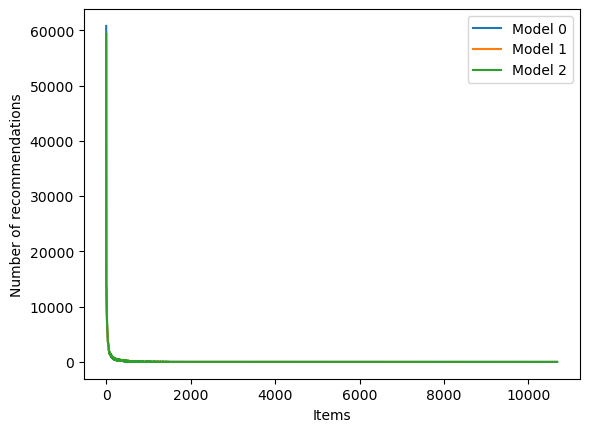

In [48]:
plot_rec_frequencies([models['P3'], P3alpha_optimal, RP3beta_optimal], URM_all)

In [24]:
# P5/P7 e come cambiano le raccomandazioni/similarity density (se la RAM regge) --> se non regge, applicare KNN come da framework (similarityMatrixTopK)
class PXRecommender(BaseRecommender):
    def __init__(self, URM, hops : int):
        self.URM = URM
        self.hops = hops
        if hops % 2 == 0:
            raise ValueError("Number of hops must be odd.")

    def fit(self):
        self.n_step_walk, _ = transition_matrix_blocks(self.URM, self.hops, extract_similarity=False)

    def recommend(self, user_id, remove_seen : bool = True, at : Optional[int] = None):
        Pi_0 = np.zeros(self.URM.shape[0], dtype=np.int32)
        Pi_0[user_id] = 1
        Pi_0 = sps.csr_matrix(Pi_0)

        ranking = Pi_0.dot(self.n_step_walk).toarray().ravel()

        if remove_seen:
            user_profile_start = self.URM.indptr[user_id]
            user_profile_end = self.URM.indptr[user_id+1]
            
            seen_items = self.URM.indices[user_profile_start:user_profile_end]
            
            ranking[seen_items] = -np.inf
            
        ranking = np.flip(np.argsort(ranking))
        return ranking[:at]

In [50]:
# Compute recommendations on test set with P3, P5 and P7
models = {
    'P3' : PXRecommender(URM_train_val, hops=3),
    'P5' : PXRecommender(URM_train_val, hops=5),
    'P7' : PXRecommender(URM_train_val, hops=7)
}

for model_name, model_obj in models.items():
    time_start = time.time()
    model_obj.fit()
    time_end_value, time_unit = seconds_to_biggest_unit(time.time() - time_start)
    # PRAXIS WHEN USING THE COURSE'S FRAMEWORK: result_df, _ = evaluator_test.evaluateRecommender(model_obj)
    _ = evaluate_recommender(URM_test, model_obj)
    print("{} trained in {:.2f} {}".format(model_name, time_end_value, time_unit))

Recommender results are: Precision = 0.0230, Recall = 0.0190, MAP = 0.0152
P3 trained in 2.83 min
Recommender results are: Precision = 0.0221, Recall = 0.0155, MAP = 0.0136
P5 trained in 3.40 min
Recommender results are: Precision = 0.0210, Recall = 0.0145, MAP = 0.0126
P7 trained in 3.91 min


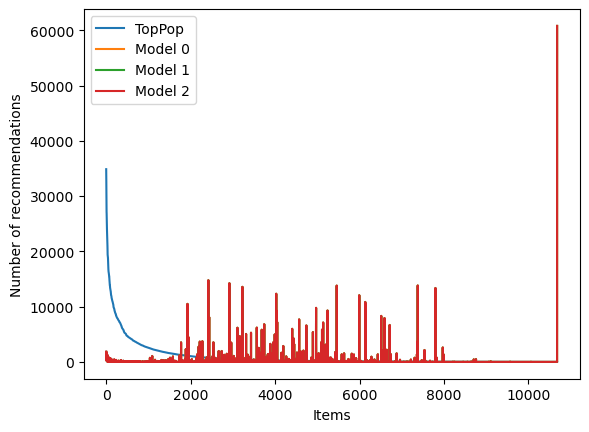

In [51]:
# Popularity plot
plot_rec_frequencies([y for _, y in models.items()], URM_all, TopPop_order=True)

Possibile ibridare modelli con hops diversi PRIO

Il codice di cui sopra è giusto "idealmente", ma non utilizzabile a livello di complessità (spazio: troppi dati da caricare in memoria). Spiego come risolvere?

Equivalenza con Item-item collaborative filtering: similarity matrix risulta uguale nelle dimensioni, possibile fare ibridi

#### Difference between $P^3_\alpha$ and $RP^3_\beta$

... Rispiegone

### Adding Content Metadata to the Mix

*Tripartite graph*: users, items, metadata

#### How do Random Walks change?

Spiegone

#### Illustrative Example

Let's restart from our little graph from before, adding 4 metadata "tags":$$\begin{bmatrix}0 & 0 & 1 & 0 & 1 & 0 & 1 & 0 & 0\\ 0 & 0 & 1 & 1 & 0 & 1 & 0 & 0 & 0 \\ 1 & 1 & 0 & 0 & 0 & 0 & 0 & 1 & 1 \\ 0 & 1 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\ 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\ 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 & 1 & 0 & 0 & 0& 0\end{bmatrix}.$$

[image] <- NO: mostra come attaccare la ICM nella matrice di adiacenza e usare i modelli del framework direttamente

In [25]:
ICM_genres = data_loaded.get_loaded_ICM_dict()["ICM_genres"]

In [35]:
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
from Evaluation.Evaluator import EvaluatorHoldout

icm_weight = 0.5 # <- tunable hyperparameter

# Train graph-based recommender
# U -> I -> [U -> I] <-- normal RP3beta
u_i_recommender = RP3betaRecommender(URM_train_val)
u_i_recommender.fit(alpha=0.5, beta=0.3, implicit=True)

# U -> I -> [A -> I] <-- tag-based RP3beta
a_i_recommender = RP3betaRecommender(ICM_genres.T)
a_i_recommender.fit(alpha=0.5, beta=0.3)

custom_similarity = u_i_recommender.W_sparse + icm_weight * a_i_recommender.W_sparse # <- additionally, you could try normalizations

# Hybrid similarity recommender
recommender = ItemKNNCustomSimilarityRecommender(URM_train_val)
recommender.fit(custom_similarity)

evaluator_test = EvaluatorHoldout(URM_test, [10])

result_df_hybrid, _ = evaluator_test.evaluateRecommender(recommender)
result_df_hybrid

RP3betaRecommender: URM Detected 33 ( 0.3%) items with no interactions.
RP3betaRecommender: Similarity column 10681 (100.0%), 1755.37 column/sec. Elapsed time 6.08 sec
RP3betaRecommender: Similarity column 10681 (100.0%), 7148.91 column/sec. Elapsed time 1.49 sec
ItemKNNCustomSimilarityRecommender: URM Detected 33 ( 0.3%) items with no interactions.
EvaluatorHoldout: Ignoring 87 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 69791 (100.0%) in 14.91 sec. Users per second: 4681


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.302068,0.345518,0.191351,0.217241,0.241384,0.604301,0.293275,0.234288,0.841584,1.096799,...,0.998755,0.840536,0.998755,0.011577,7.066748,0.986683,0.059455,0.623998,2.085273,0.070008


È possibile attaccare i metadati col framework? Nel caso, mostragli come.

- Part 1: generic structure of a graph
    - Nodes
    - Edges
    - (E.g. : Gif of my knowledge graph on Obsidian)
    - Notation: chart OR adjacency matrix OR adjacency lists
        - Adjacency matrices: node2node OR node2edge
            - For our purpose, we use node2node adjacency matrices
- Part 2: graphs in recommendation
    - Nodes: users, items
    - Edges: interactions
    - Bipartite graph: we can distinguish 2 classes of nodes, with edges only connecting nodes of class 1 to nodes of class 2 and vice-versa. No inter-class connections
        - Adjacency matrix of a graph of interactions: URM!
            - `G = [[[0][URM]], [[URM*], [0]]]`
    - Path: sequence of connected nodes that starts with node A and ends with node B
        - Recommendation idea: we can use paths as collaborative signals
- Part 3: random walks
    - Recap on mathematics (from textbook)
    - Illustrative example (from slides)
- Part 4: $P^3$, $P^3_\alpha$, $RP^3_\beta$
    - $P^3$: 3-step random walks
        - Theory recap (from textbook, don't explain)
        - Illustrative example (from slides)
    - $P^3_\alpha$: add an exponent
        - Theory recap (from textbook, don't explain)
        - Illustrative example (from slides)
    - $RP^3_\beta$: ...
        - Theory recap (from textbook, don't explain)
        - How to use (from framework), strong baseline! Good for hybrids
- Part 5: Adding item metadata, tripartite graph
    - Theory recap (from slides)
    - Illustrative example with $P^3$